In [1]:
import nibabel as nib
import numpy as np
import os
import matplotlib.pyplot as plt
from nilearn.plotting import plot_stat_map, plot_anat, plot_img
from pathlib import Path
from ipywidgets import IntSlider, interact
import pywt

In [2]:
def plot_img(img, cmap = 'gray'):
    plt.figure(figsize=(12,8))
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.show()

In [3]:
#делаем из сырых срезов мрт 3d картинку 
import dicom2nifti
dicom2nifti.dicom_series_to_nifti('0_1', '0_1.nii.gz', reorient_nifti=True)

{'NII_FILE': '0_1.nii.gz',
 'NII': <nibabel.nifti1.Nifti1Image at 0x7f84ec0ce450>,
 'MAX_SLICE_INCREMENT': 0.8000000317891441}

In [4]:
# скачиваем себе эту 3d картинку
brain = nib.load('0_1.nii.gz')

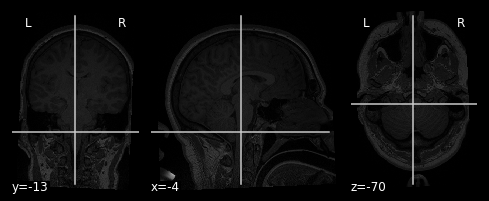

In [5]:
plot_anat(brain)

In [6]:
brain = brain.get_fdata()

In [7]:
brain.shape

(192, 352, 352)

In [11]:
sld_sagital = IntSlider(min=0, max=brain.shape[0]-1, step=1, continuous_update=True)
sld_coronal = IntSlider(min=0, max=brain.shape[1]-1, step=1, continuous_update=True)
sld_axial   = IntSlider(min=0, max=brain.shape[2]-1, step=1, continuous_update=True)

In [12]:
def vary_coordinate(coordinate_sagital, coordinate_coronal, coordinate_axial, axis = None):
    if axis == None:
        pass
    if axis == 'sagital':
        plot_img(brain[coordinate_sagital,:,:])
    if axis == 'coronal':
        plot_img(brain[:,coordinate_coronal ,:])
    if axis == 'axial':
        plot_img(brain[:,:, coordinate_axial])

In [13]:
interact(vary_coordinate, 
         coordinate_axial = sld_axial,
         coordinate_sagital = sld_sagital,
         coordinate_coronal = sld_coronal,
         axis = 'axial')

interactive(children=(IntSlider(value=0, description='coordinate_sagital', max=191), IntSlider(value=0, descri…

<function __main__.vary_coordinate(coordinate_sagital, coordinate_coronal, coordinate_axial, axis=None)>

In [14]:
A1 = brain[:,:,225].T

In [15]:
print(f'mean = {A1.mean()}')
print(f'variance = {A1.var()}')

mean = 211.5997869318182
variance = 25163.32228096786


In [16]:
A2 = (A1 - A1.mean())/A1.std()
#A2 = (A1 - A1.min())/(A1.max() - A1.min())

In [18]:
print(f'mean = {A2.mean()}')
print(f'variance = {A2.var()}')

mean = -4.0371746350005693e-17
variance = 1.0000000000000002


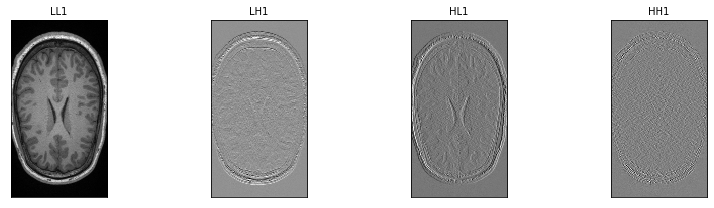

In [19]:
titles = ['LL1', 'LH1', 'HL1', 'HH1']

w = pywt.Wavelet('db1')
coeffs = pywt.dwt2(A1, w)

LL1, (LH1, HL1, HH1) = coeffs

fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL1, LH1, HL1, HH1]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()



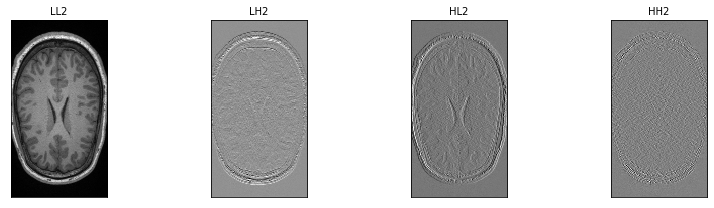

In [20]:
titles = ['LL2', 'LH2', 'HL2', 'HH2']

w = pywt.Wavelet('db1')
coeffs = pywt.dwt2(A2, w)

LL2, (LH2, HL2, HH2) = coeffs

fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL2, LH2, HL2, HH2]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()


## SVD of LL's 

In [21]:
U1, S1, V1 = np.linalg.svd(LL1, full_matrices = False)
U2, S2, V2 = np.linalg.svd(LL2, full_matrices = False)

## Different methods of finding $\xi$

In [22]:
xi_1 = S2[0]/S1[0]

In [23]:
xi_2 = U2.max()/U1.max()

In [24]:
xi_3 = (U2.max() + V2.max())/(U1.max() + V1.max())

## New $\Sigma$ 

In [25]:
def new_sigma1(sigma2, xi):
    return xi*sigma2

In [26]:
def new_sigma2(sigma1, sigma2, xi):
    return 0.5*(xi*sigma1+sigma2/xi)

In [27]:
def new_sigma3(sigma1, sigma2, xi, mu):
    return mu*xi*sigma1 + (1-mu)*sigma2/xi

## New LL 

In [28]:
def new_LL(new_sigma):
    new_sigma = np.diag(new_sigma)
    return U2 @ new_sigma @ V2

## Experiments with different approaches

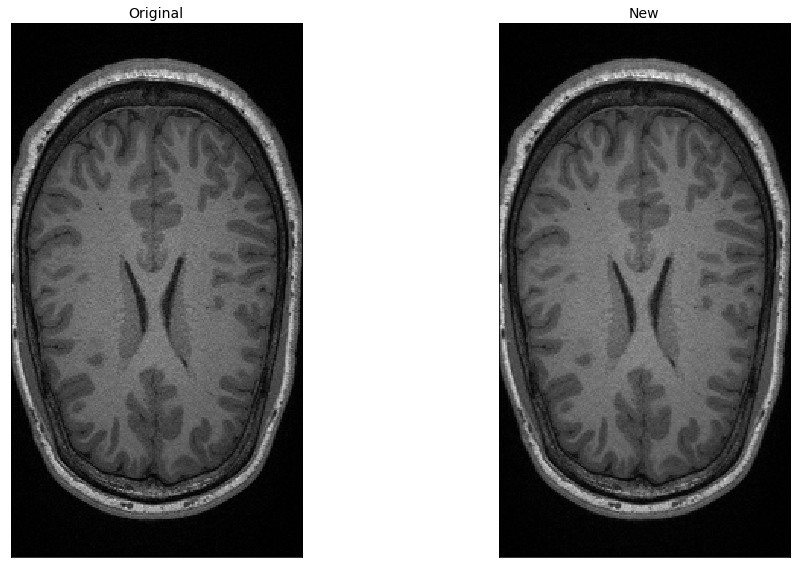

In [29]:
# Article of 2014
new_S = new_sigma1(S2, xi_2)
LL = new_LL(new_S)
brain1 = pywt.idwt2((LL, (LH2, HL2, HH2)), w)

titles = ['Original', 'New']
fig = plt.figure(figsize=(16, 8))
for i, a in enumerate([A2, brain1]):
    ax = fig.add_subplot(1, 2, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=14)
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()
plt.show()

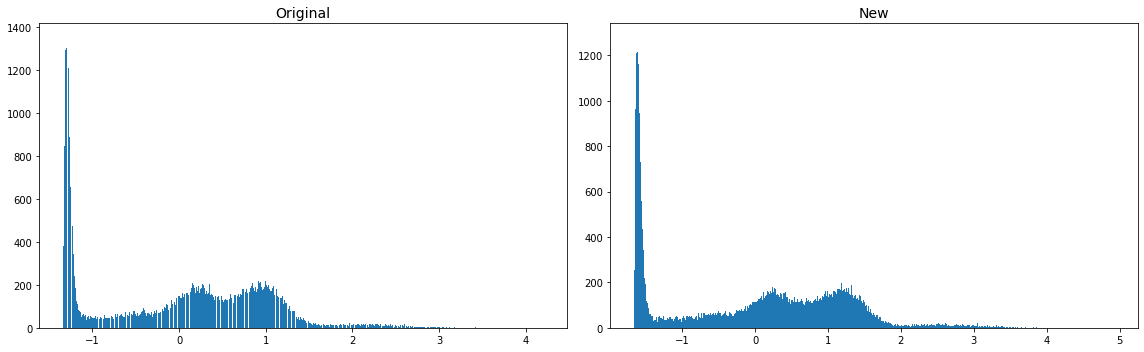

In [30]:
titles = ['Original', 'New']
fig = plt.figure(figsize=(16, 5))
for i, a in enumerate([A2, brain1]):
    ax = fig.add_subplot(1, 2, i + 1)
    ax.hist(a.reshape(-1), bins = 1000)
    ax.set_title(titles[i], fontsize=14)
fig.tight_layout()
plt.show()

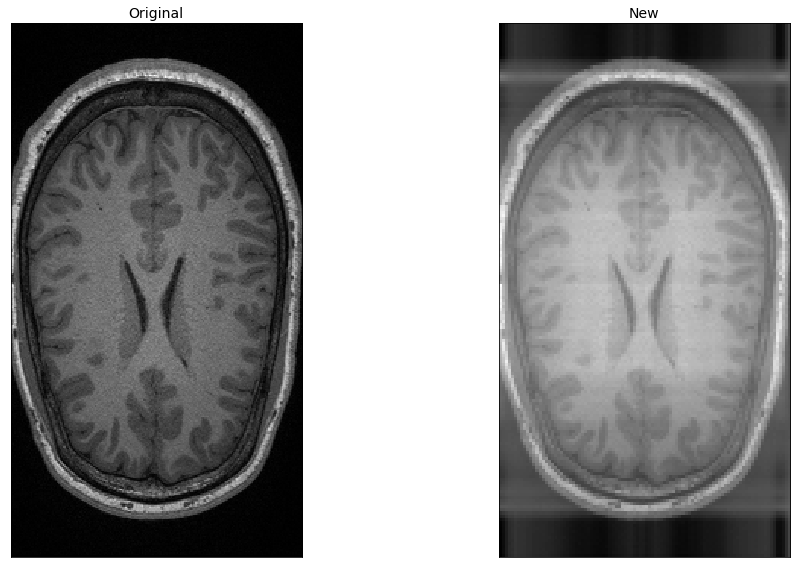

In [31]:
# Article of 2015
new_S = new_sigma2(S1, S2, xi_3)
LL = new_LL(new_S)
brain2 = pywt.idwt2((LL, (LH2, HL2, HH2)), w)

titles = ['Original', 'New']
fig = plt.figure(figsize=(16, 8))
for i, a in enumerate([A2, brain2]):
    ax = fig.add_subplot(1, 2, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=14)
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()
plt.show()

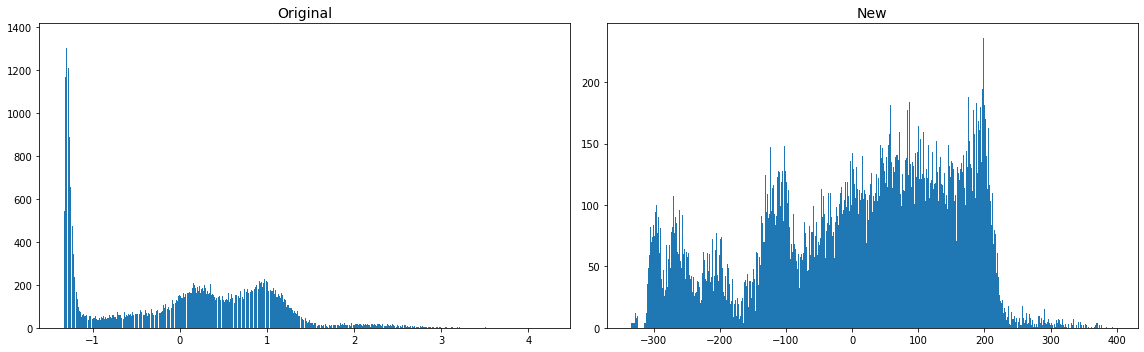

In [32]:
titles = ['Original', 'New']
fig = plt.figure(figsize=(16, 5))
for i, a in enumerate([A2, brain2]):
    ax = fig.add_subplot(1, 2, i + 1)
    ax.hist(a.reshape(-1), bins = 1000)
    ax.set_title(titles[i], fontsize=14)
fig.tight_layout()
plt.show()

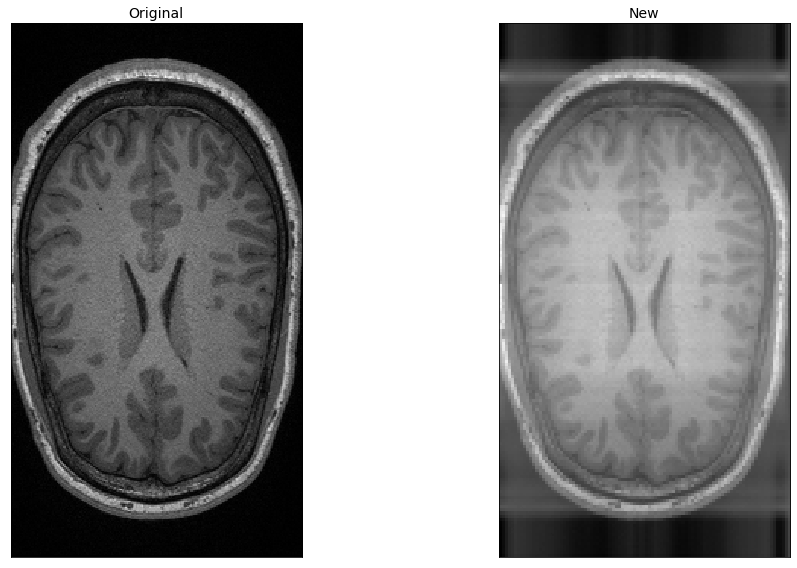

In [33]:
# Main article

mu = 0.1
new_S = new_sigma3(S1, S2, xi_3, mu)
LL = new_LL(new_S)
brain3 = pywt.idwt2((LL, (LH2, HL2, HH2)), w)

titles = ['Original', 'New']
fig = plt.figure(figsize=(16, 8))
for i, a in enumerate([A2, brain3]):
    ax = fig.add_subplot(1, 2, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=14)
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()
plt.show()

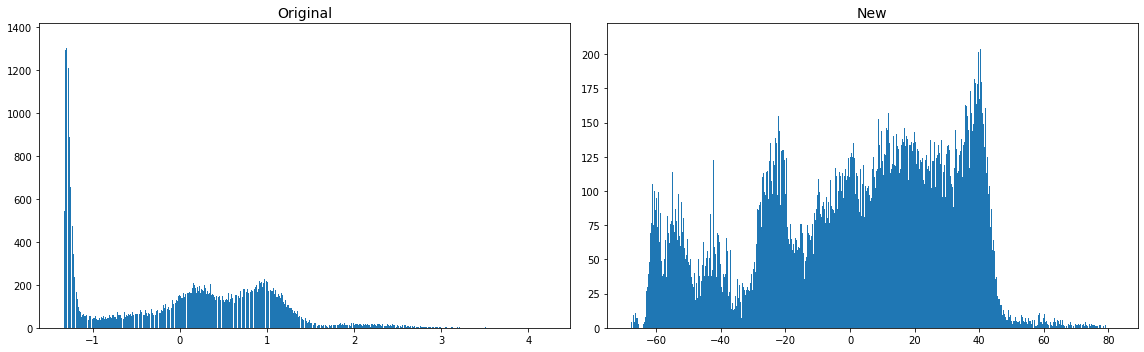

In [34]:
titles = ['Original', 'New']
fig = plt.figure(figsize=(16, 5))
for i, a in enumerate([A2, brain3]):
    ax = fig.add_subplot(1, 2, i + 1)
    ax.hist(a.reshape(-1), bins = 1000)
    ax.set_title(titles[i], fontsize=14)
fig.tight_layout()
plt.show()